## IMPORT LIBRARY

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import skew
from scipy.stats import zscore

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

## LOAD DATASET

In [2]:
# load dataset
df = pd.read_csv('Customer_Segmentation.csv')
df.head(10)

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18","1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66","3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,"1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69","2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14","1,822.40"
5,SO - 000106,Online,WARE-PUJ1005,31/12/17,31/5/18,8/6/18,13/6/18,USD,12,21,285,1,5,0.050,446.56,"1,038.50"
6,SO - 000107,In-Store,WARE-XYS1001,31/12/17,31/5/18,8/6/18,14/6/18,USD,10,14,6,5,4,0.150,536.67,"1,192.60"
7,SO - 000108,In-Store,WARE-PUJ1005,10/4/18,31/5/18,26/6/18,1/7/18,USD,6,9,280,46,5,0.050,"1,525.19","1,815.70"
8,SO - 000109,In-Store,WARE-PUJ1005,31/12/17,1/6/18,16/6/18,21/6/18,USD,4,9,299,47,4,0.300,"2,211.20","3,879.30"
9,SO - 000110,In-Store,WARE-UHY1004,31/12/17,1/6/18,29/6/18,1/7/18,USD,10,33,261,13,8,0.050,"1,212.97","1,956.40"


In [3]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderNumber       7991 non-null   object 
 1   Sales Channel     7991 non-null   object 
 2   WarehouseCode     7991 non-null   object 
 3   ProcuredDate      7991 non-null   object 
 4   OrderDate         7991 non-null   object 
 5   ShipDate          7991 non-null   object 
 6   DeliveryDate      7991 non-null   object 
 7   CurrencyCode      7991 non-null   object 
 8   _SalesTeamID      7991 non-null   int64  
 9   _CustomerID       7991 non-null   int64  
 10  _StoreID          7991 non-null   int64  
 11  _ProductID        7991 non-null   int64  
 12  Order Quantity    7991 non-null   int64  
 13  Discount Applied  7991 non-null   float64
 14  Unit Cost         7991 non-null   object 
 15  Unit Price        7991 non-null   object 
dtypes: float64(1), int64(5), object(10)
memory

## DATA PRE-PROCESSING

In [4]:
# The replace() method with regex=True replaces all blank spaces (\s*) with NaN values in the entire DataFrame
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [5]:
# check missing value
df.isnull().sum()

OrderNumber         0
Sales Channel       0
WarehouseCode       0
ProcuredDate        0
OrderDate           0
ShipDate            0
DeliveryDate        0
CurrencyCode        0
_SalesTeamID        0
_CustomerID         0
_StoreID            0
_ProductID          0
Order Quantity      0
Discount Applied    0
Unit Cost           0
Unit Price          0
dtype: int64

In [6]:
# check duplicated
df.duplicated().sum()

0

In [7]:
# convert to datetime in each column
def convert_to_datetime(df, columns):
    for col in columns:
        if col in df.columns and df[col].dtype == 'O':
            df[col] = pd.to_datetime(df[col], errors='coerce')

convert_to_datetime(df, columns=['ProcuredDate', 'OrderDate', 'ShipDate', 'DeliveryDate'])

In [8]:
# remove underscore in each column
def remove_underscore(df, columns):
    for col in columns:
        if col in df.columns:
            df.rename(columns={col: col.replace('_', '')}, inplace=True)

remove_underscore(df, columns=['_SalesTeamID', '_CustomerID', '_StoreID', '_ProductID'])

In [9]:
# convert to float in each column
def convert_to_float(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: float(x.replace(',', '')) if ',' in x else float(x))

convert_to_float(df, columns=['Unit Cost', 'Unit Price'])

In [10]:
# convert to string in each column
def convert_to_string(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str)

convert_to_string(df, columns=['CustomerID', 'ProductID', 'StoreID', 'SalesTeamID'])

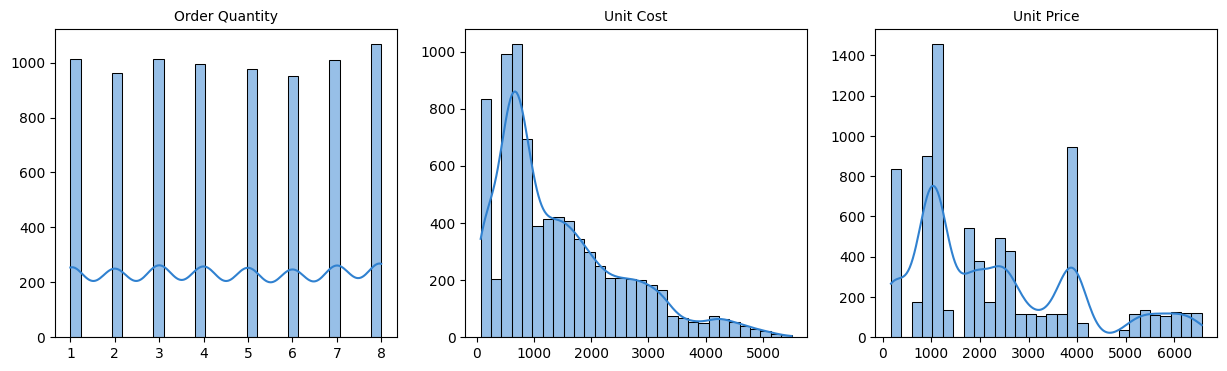

In [11]:
# check outlier using boxplot
cols = ['Order Quantity', 'Unit Cost', 'Unit Price']

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for i, col in enumerate(cols):
    sns.histplot(x=df[col], kde=True, ax=axs[i], color='#3081D0', bins=30)
    axs[i].set_title(col, fontsize=10)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

plt.show()

In [12]:
df['TotalPurchase'] = df['Unit Price'] * df['Order Quantity']
# df['TotalPriceDiscount'] = (df['Unit Price'] * df['Order Quantity']) * df['Discount Applied']
# df['TotalPurchase'] = df['TotalPrice'] - df['TotalPriceDiscount']

df['TotalCost'] = df['Unit Cost'] * df['Order Quantity']

df['TotalProfit'] = df['TotalPurchase'] - df['TotalCost']

In [13]:
df = df.rename(columns={'Sales Channel': 'SalesChannel',
                        'Order Quantity': 'OrderQuantity',
                        'Discount Applied': 'DiscountApplied',
                        'Unit Cost': 'UnitCost',
                        'Unit Price': 'UnitPrice'})

In [14]:
# sort column names
col_order = ['CustomerID', 'OrderNumber', 'OrderDate', 'ShipDate', 'DeliveryDate', 'ProcuredDate', 'ProductID', 'OrderQuantity', 'DiscountApplied', 'UnitCost', 'UnitPrice', 
             'TotalPurchase', 'TotalCost', 'TotalProfit', 'CurrencyCode', 'StoreID', 'WarehouseCode', 'SalesTeamID', 'SalesChannel']
df = df[col_order]

In [15]:
df.head(10)

,CustomerID,OrderNumber,OrderDate,ShipDate,DeliveryDate,ProcuredDate,ProductID,OrderQuantity,DiscountApplied,UnitCost,UnitPrice,TotalPurchase,TotalCost,TotalProfit,CurrencyCode,StoreID,WarehouseCode,SalesTeamID,SalesChannel
0,15,SO - 000101,2018-05-31,2018-06-14,2018-06-19,2017-12-31,12,5,0.075,1001.180,1963.100,9815.500,5005.900,4809.600,USD,259,WARE-UHY1004,6,In-Store
1,20,SO - 000102,2018-05-31,2018-06-22,2018-02-07,2017-12-31,27,3,0.075,3348.660,3939.600,11818.800,10045.980,1772.820,USD,196,WARE-NMK1003,14,Online
2,16,SO - 000103,2018-05-31,2018-06-21,2018-01-07,2017-12-31,16,1,0.050,781.220,1775.500,1775.500,781.220,994.280,USD,213,WARE-UHY1004,21,Distributor
3,48,SO - 000104,2018-05-31,2018-02-06,2018-07-06,2017-12-31,23,8,0.075,1464.690,2324.900,18599.200,11717.520,6881.680,USD,107,WARE-NMK1003,28,Wholesale
4,49,SO - 000105,2018-05-31,2018-06-16,2018-06-26,2018-10-04,26,8,0.100,1476.140,1822.400,14579.200,11809.120,2770.080,USD,111,WARE-NMK1003,22,Distributor
5,21,SO - 000106,2018-05-31,2018-08-06,2018-06-13,2017-12-31,1,5,0.050,446.560,1038.500,5192.500,2232.800,2959.700,USD,285,WARE-PUJ1005,12,Online
6,14,SO - 000107,2018-05-31,2018-08-06,2018-06-14,2017-12-31,5,4,0.150,536.670,1192.600,4770.400,2146.680,2623.720,USD,6,WARE-XYS1001,10,In-Store
7,9,SO - 000108,2018-05-31,2018-06-26,2018-01-07,2018-10-04,46,5,0.050,1525.190,1815.700,9078.500,7625.950,1452.550,USD,280,WARE-PUJ1005,6,In-Store
8,9,SO - 000109,2018-01-06,2018-06-16,2018-06-21,2017-12-31,47,4,0.300,2211.200,3879.300,15517.200,8844.800,6672.400,USD,299,WARE-PUJ1005,4,In-Store
9,33,SO - 000110,2018-01-06,2018-06-29,2018-01-07,2017-12-31,13,8,0.050,1212.970,1956.400,15651.200,9703.760,5947.440,USD,261,WARE-UHY1004,10,In-Store


In [16]:
# dataset information after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       7991 non-null   object        
 1   OrderNumber      7991 non-null   object        
 2   OrderDate        7991 non-null   datetime64[ns]
 3   ShipDate         7991 non-null   datetime64[ns]
 4   DeliveryDate     7991 non-null   datetime64[ns]
 5   ProcuredDate     7991 non-null   datetime64[ns]
 6   ProductID        7991 non-null   object        
 7   OrderQuantity    7991 non-null   int64         
 8   DiscountApplied  7991 non-null   float64       
 9   UnitCost         7991 non-null   float64       
 10  UnitPrice        7991 non-null   float64       
 11  TotalPurchase    7991 non-null   float64       
 12  TotalCost        7991 non-null   float64       
 13  TotalProfit      7991 non-null   float64       
 14  CurrencyCode     7991 non-null   object 

## EXPLORATORY DATA ANALYSIS

In [17]:
exclude = ['OrderDate', 'ShipDate', 'DeliveryDate', 'ProcuredDate']
df.drop(columns=exclude).describe()

,OrderQuantity,DiscountApplied,UnitCost,UnitPrice,TotalPurchase,TotalCost,TotalProfit
count,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000
mean,4.525,0.114,1431.912,2284.537,10348.233,6484.554,3863.679
std,2.313,0.086,1112.413,1673.096,10021.420,6556.446,4196.856
min,1.000,0.050,68.680,167.500,167.500,73.700,25.120
25%,3.000,0.050,606.120,1031.800,3195.900,1833.920,1013.515
50%,5.000,0.075,1080.580,1849.200,6994.800,4206.020,2398.600
75%,7.000,0.150,2040.250,3611.300,14780.200,8975.860,5094.160
max,8.000,0.400,5498.560,6566.000,52313.600,42308.080,30905.760


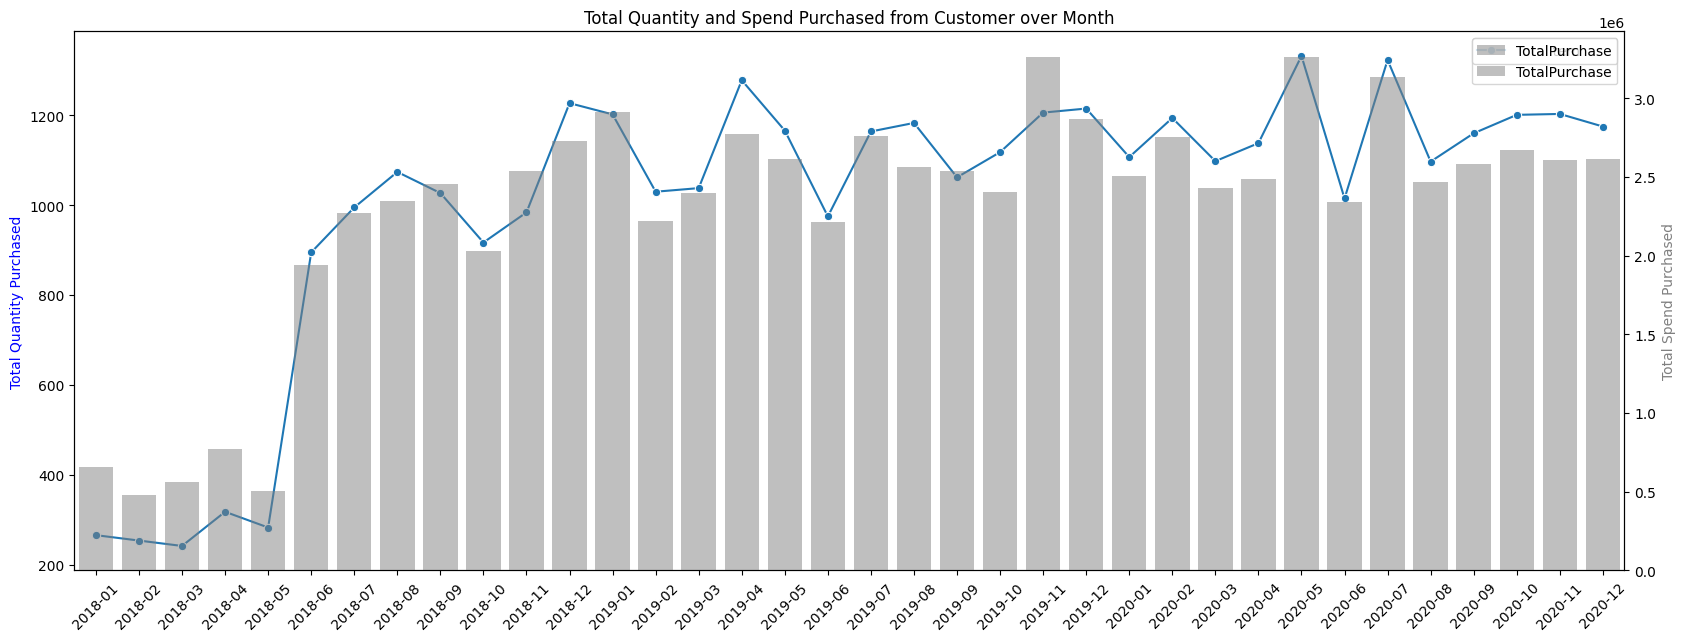

In [18]:
# visualization of total quantity purchased and total spend from customer per month
df['YearMonth'] = df['OrderDate'].dt.to_period('M')
monthly_item_counts = df.groupby('YearMonth')['OrderQuantity'].sum().reset_index(name='TotalItem')
monthly_item_counts['YearMonth'] = monthly_item_counts['YearMonth'].astype(str)

plt.figure(figsize=(20, 7))
ax1 = sns.lineplot(x='YearMonth', y='TotalItem', data=monthly_item_counts, marker='o', label='TotalItem')
ax2 = ax1.twinx()
sns.barplot(x='YearMonth', y='TotalPurchase', data=df.groupby('YearMonth')['TotalPurchase'].sum().reset_index(), ax=ax2, color='gray', 
            alpha=0.5, label='TotalPurchase')

ax1.set_title('Total Quantity and Spend Purchased from Customer over Month')
ax1.set_xlabel('')
ax1.set_ylabel('Total Quantity Purchased', color='blue')
ax2.set_ylabel('Total Spend Purchased', color='gray')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper right')
plt.show()

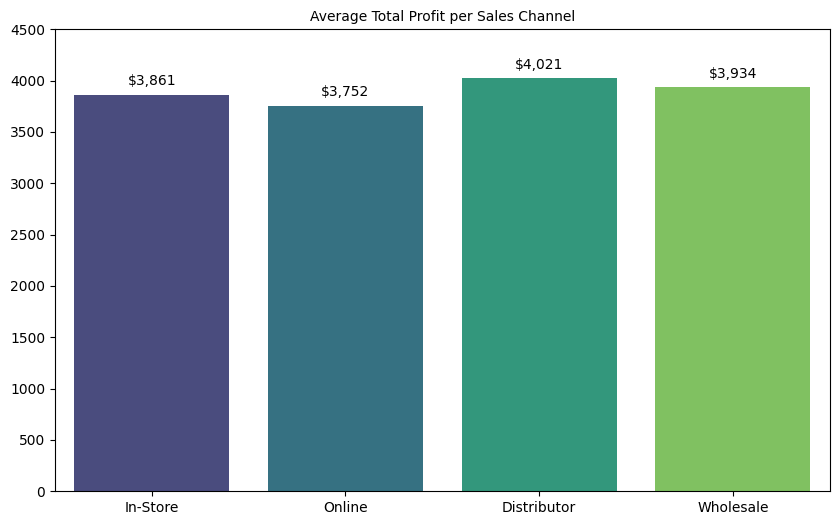

In [19]:
# sales channel based on its average profit
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='SalesChannel', y='TotalProfit', data=df, ci=None, palette='viridis')

for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.ylim(0, + 4500)
plt.title('Average Total Profit per Sales Channel', fontsize=10)
plt.xlabel('')
plt.ylabel('')
plt.show()

## RFM CALCULATION

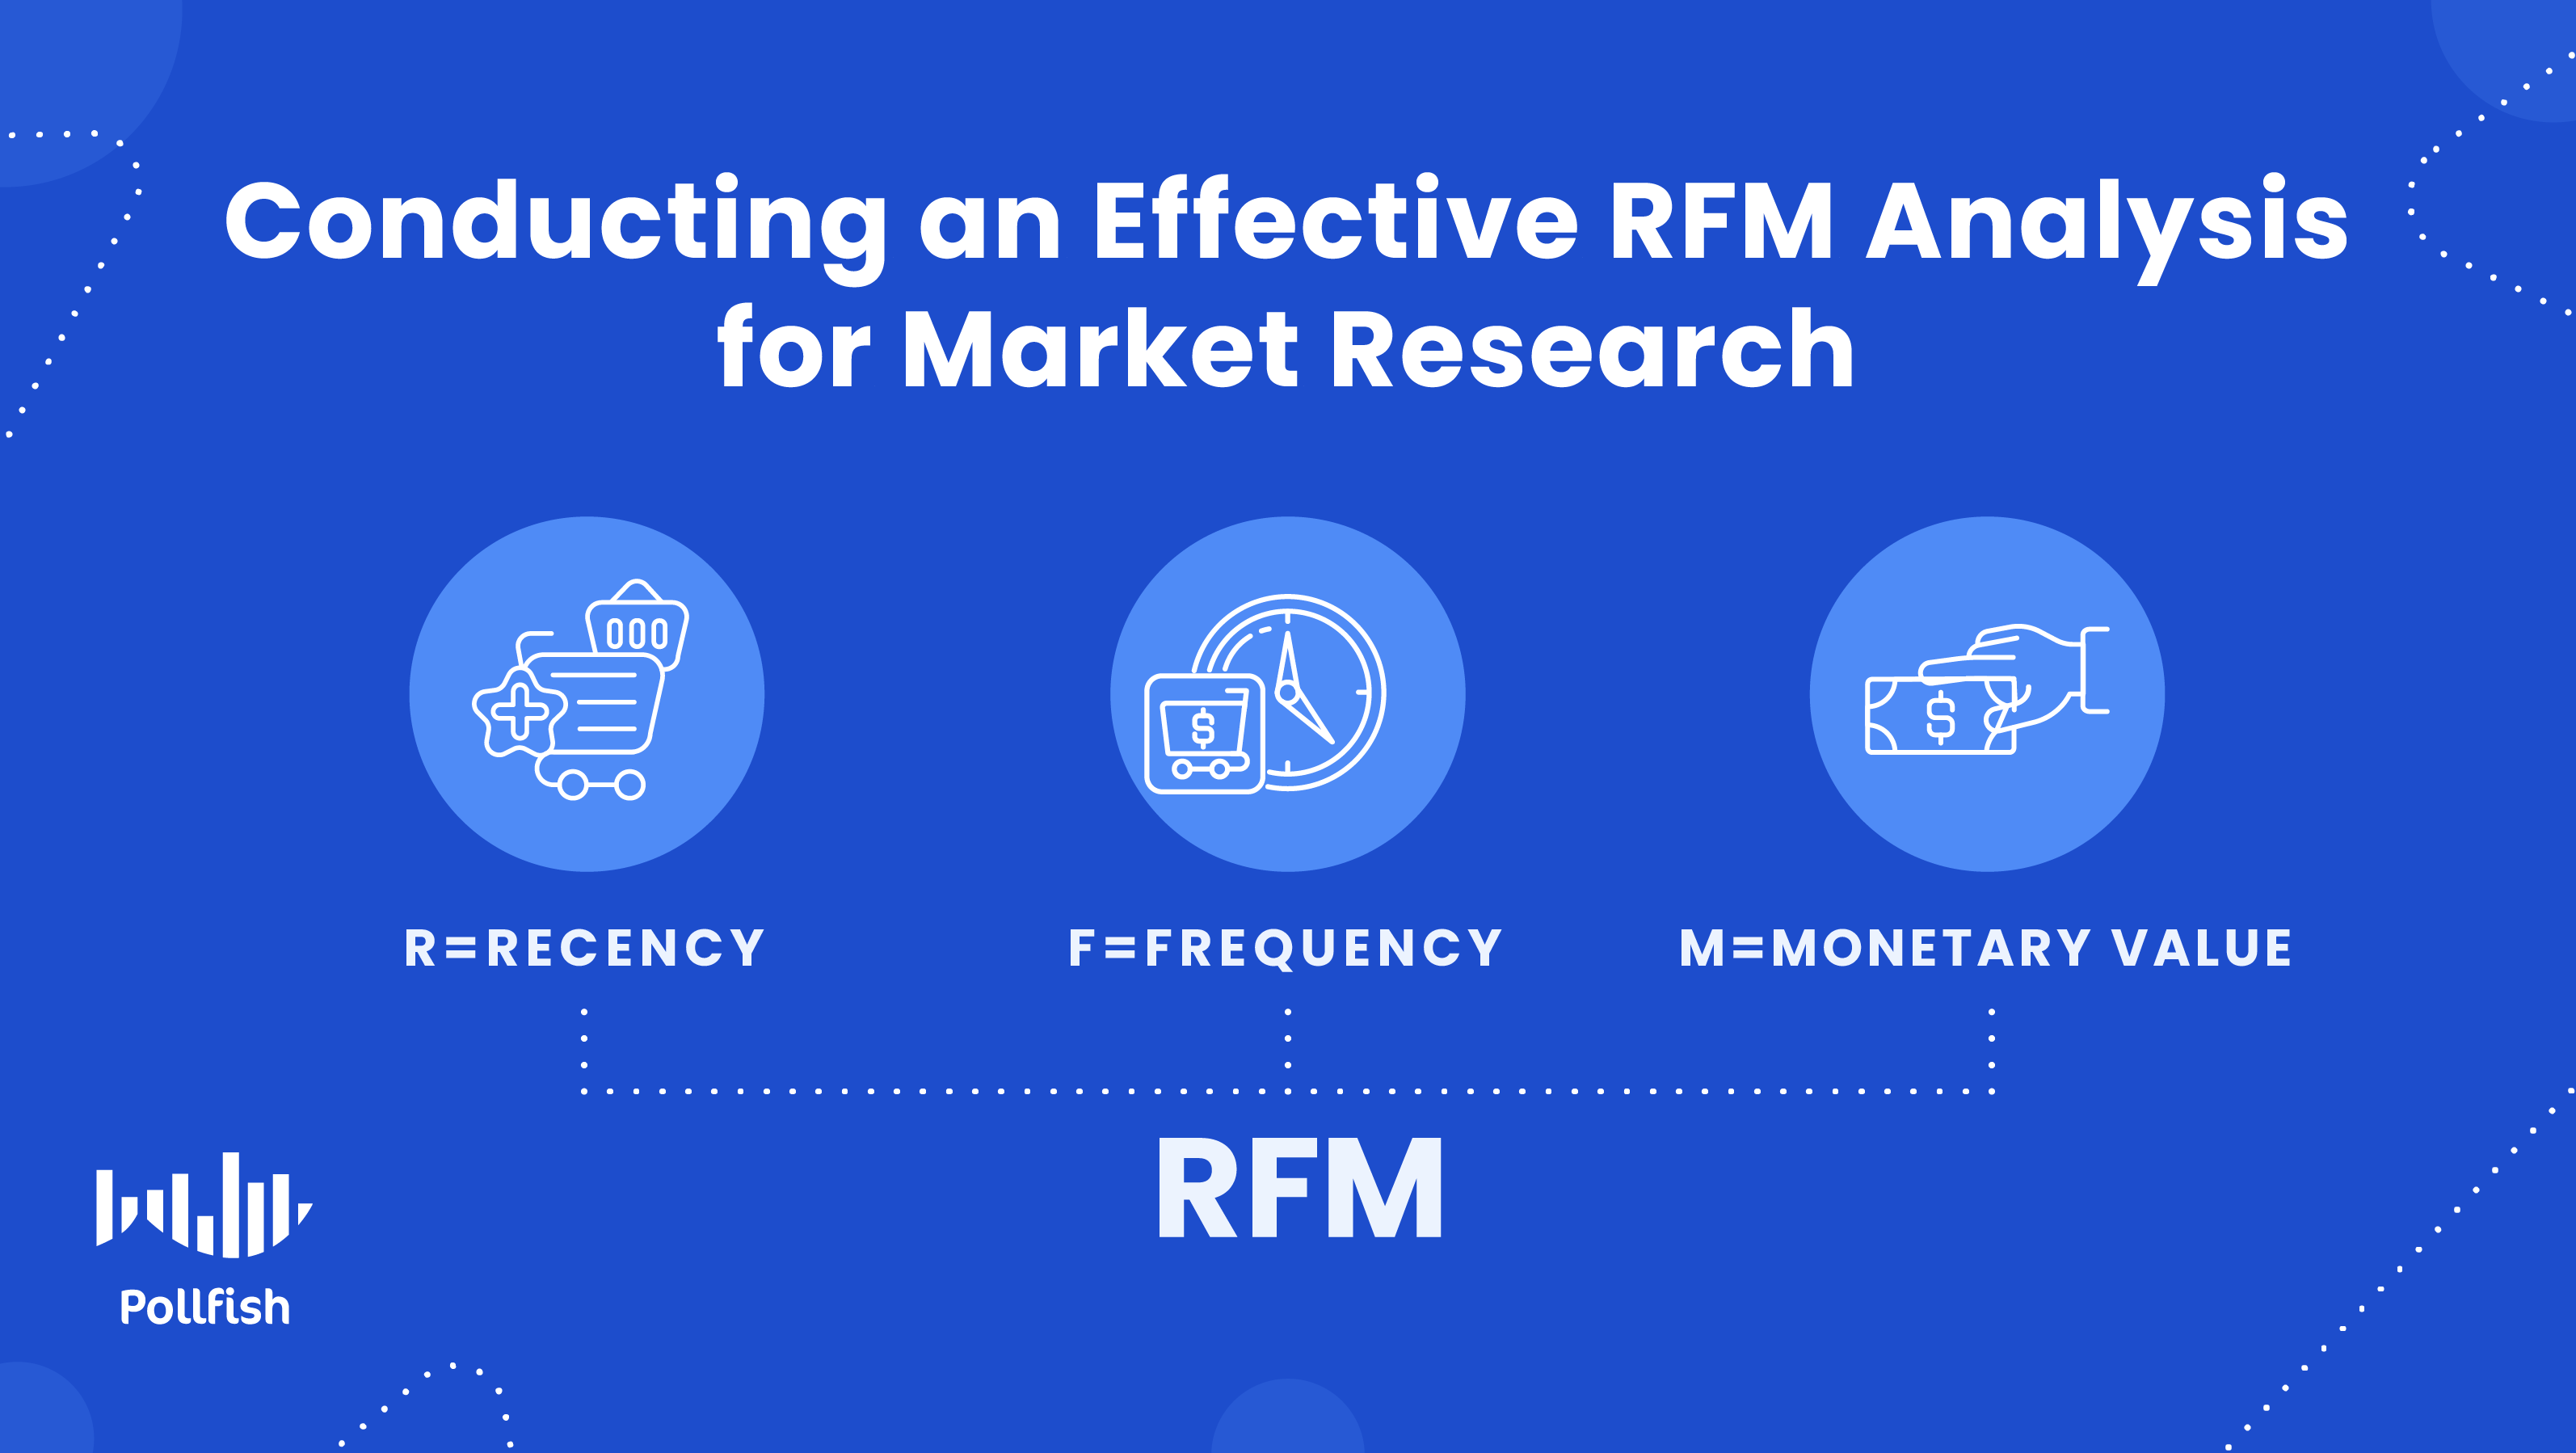

In [20]:
from IPython.display import Image, display

img_path = 'RFM.png'
display(Image(filename=img_path, width=1500))

In [21]:
df['FirstPurchase'] = df.groupby('CustomerID')['OrderDate'].transform('min')

segment = df.groupby('CustomerID', as_index=False).agg(
                     Frequency=('OrderNumber', 'nunique'),
                     TotalQuantityOrder=('OrderQuantity', 'sum'),
                     LastSpending=('OrderDate', 'max'),
                     TotalSpending=('TotalPurchase', 'sum'),
                     TotalProfit=('TotalProfit', 'sum'),
                     FirstPurchase=('FirstPurchase', 'min')
)

last_order = df['OrderDate'].max()

segment['Recency'] = (last_order - segment['LastSpending']).dt.days
segment['Monetary'] = segment['TotalSpending']

col_order = ['CustomerID', 'FirstPurchase', 'LastSpending', 'TotalQuantityOrder', 'TotalSpending', 'TotalProfit', 'Recency', 'Frequency', 'Monetary']
segment = segment[col_order]

print(segment.head(10).to_string())

  CustomerID FirstPurchase LastSpending  TotalQuantityOrder  TotalSpending  TotalProfit  Recency  Frequency    Monetary
0          1    2018-02-07   2020-12-23                 635    1322278.500   483190.900        7        152 1322278.500
1         10    2018-01-06   2020-12-17                 706    1763942.500   618305.360       13        158 1763942.500
2         11    2018-01-06   2020-12-26                 805    1883410.200   712098.980        4        178 1883410.200
3         12    2018-02-11   2020-12-29                 970    2248332.400   852174.170        1        210 2248332.400
4         13    2018-01-09   2020-12-28                 765    1868321.800   636107.130        2        171 1868321.800
5         14    2018-01-11   2020-12-27                 681    1452225.000   571399.980        3        157 1452225.000
6         15    2018-01-11   2020-12-28                 627    1512726.000   608038.480        2        142 1512726.000
7         16    2018-04-08   2020-12-29 

## RFM SEGMENTATION

In [22]:
segment['RecencyRank'] = segment['Recency'].rank( ascending=False)
segment['FrequencyRank'] = segment['Frequency'].rank(ascending=True)
segment['MonetaryRank'] = segment['Monetary'].rank(ascending=True)

In [23]:
segment['RecencyRankNorm'] = (segment['RecencyRank'] / segment['RecencyRank'].max())*100
segment['FrequencyRankNorm'] = (segment['FrequencyRank'] / segment['FrequencyRank'].max())*100
segment['MonetaryRankNorm'] = (segment['MonetaryRank'] / segment['MonetaryRank'].max())*100

In [24]:
segment['RFMScore'] = (0.15 * segment['RecencyRankNorm']) + (0.28 * segment['FrequencyRankNorm']) + (0.57 * segment['MonetaryRankNorm'])
segment['RFMScore'] = segment['RFMScore'].round(0)

segment['RFMSegment'] = np.where(segment['RFMScore'] > 75 ,"High Value Customer",(np.where(segment['RFMScore'] < 50 , "Low Value Customer" ,"Medium Value Customer")))
print(segment.head(10).to_string())

  CustomerID FirstPurchase LastSpending  TotalQuantityOrder  TotalSpending  TotalProfit  Recency  Frequency    Monetary  RecencyRank  FrequencyRank  MonetaryRank  RecencyRankNorm  FrequencyRankNorm  MonetaryRankNorm  RFMScore             RFMSegment
0          1    2018-02-07   2020-12-23                 635    1322278.500   483190.900        7        152 1322278.500       13.500         15.500         1.000           27.835             31.000             2.000    14.000     Low Value Customer
1         10    2018-01-06   2020-12-17                 706    1763942.500   618305.360       13        158 1763942.500        4.500         26.000        35.000            9.278             52.000            70.000    56.000  Medium Value Customer
2         11    2018-01-06   2020-12-26                 805    1883410.200   712098.980        4        178 1883410.200       22.000         46.000        45.000           45.361             92.000            90.000    84.000    High Value Customer
3   

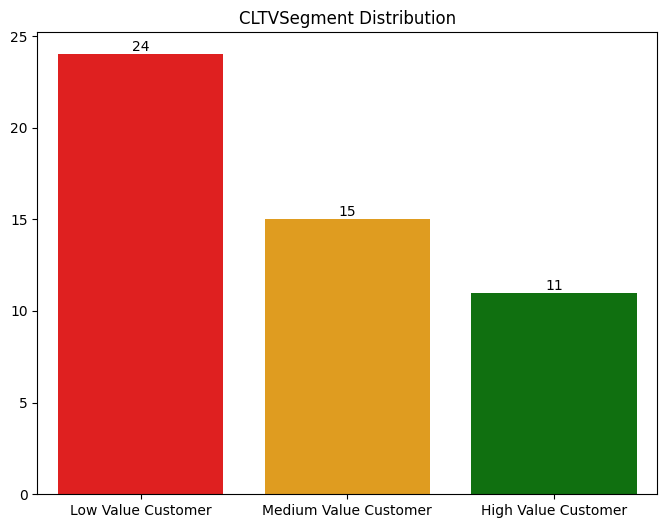

In [25]:
custom_palette = {'Low Value Customer': 'red', 'Medium Value Customer': 'orange', 'High Value Customer': 'green'}

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=segment, x=segment['RFMSegment'], palette=custom_palette)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('CLTVSegment Distribution', loc='center', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

## CLTV CALCULATION

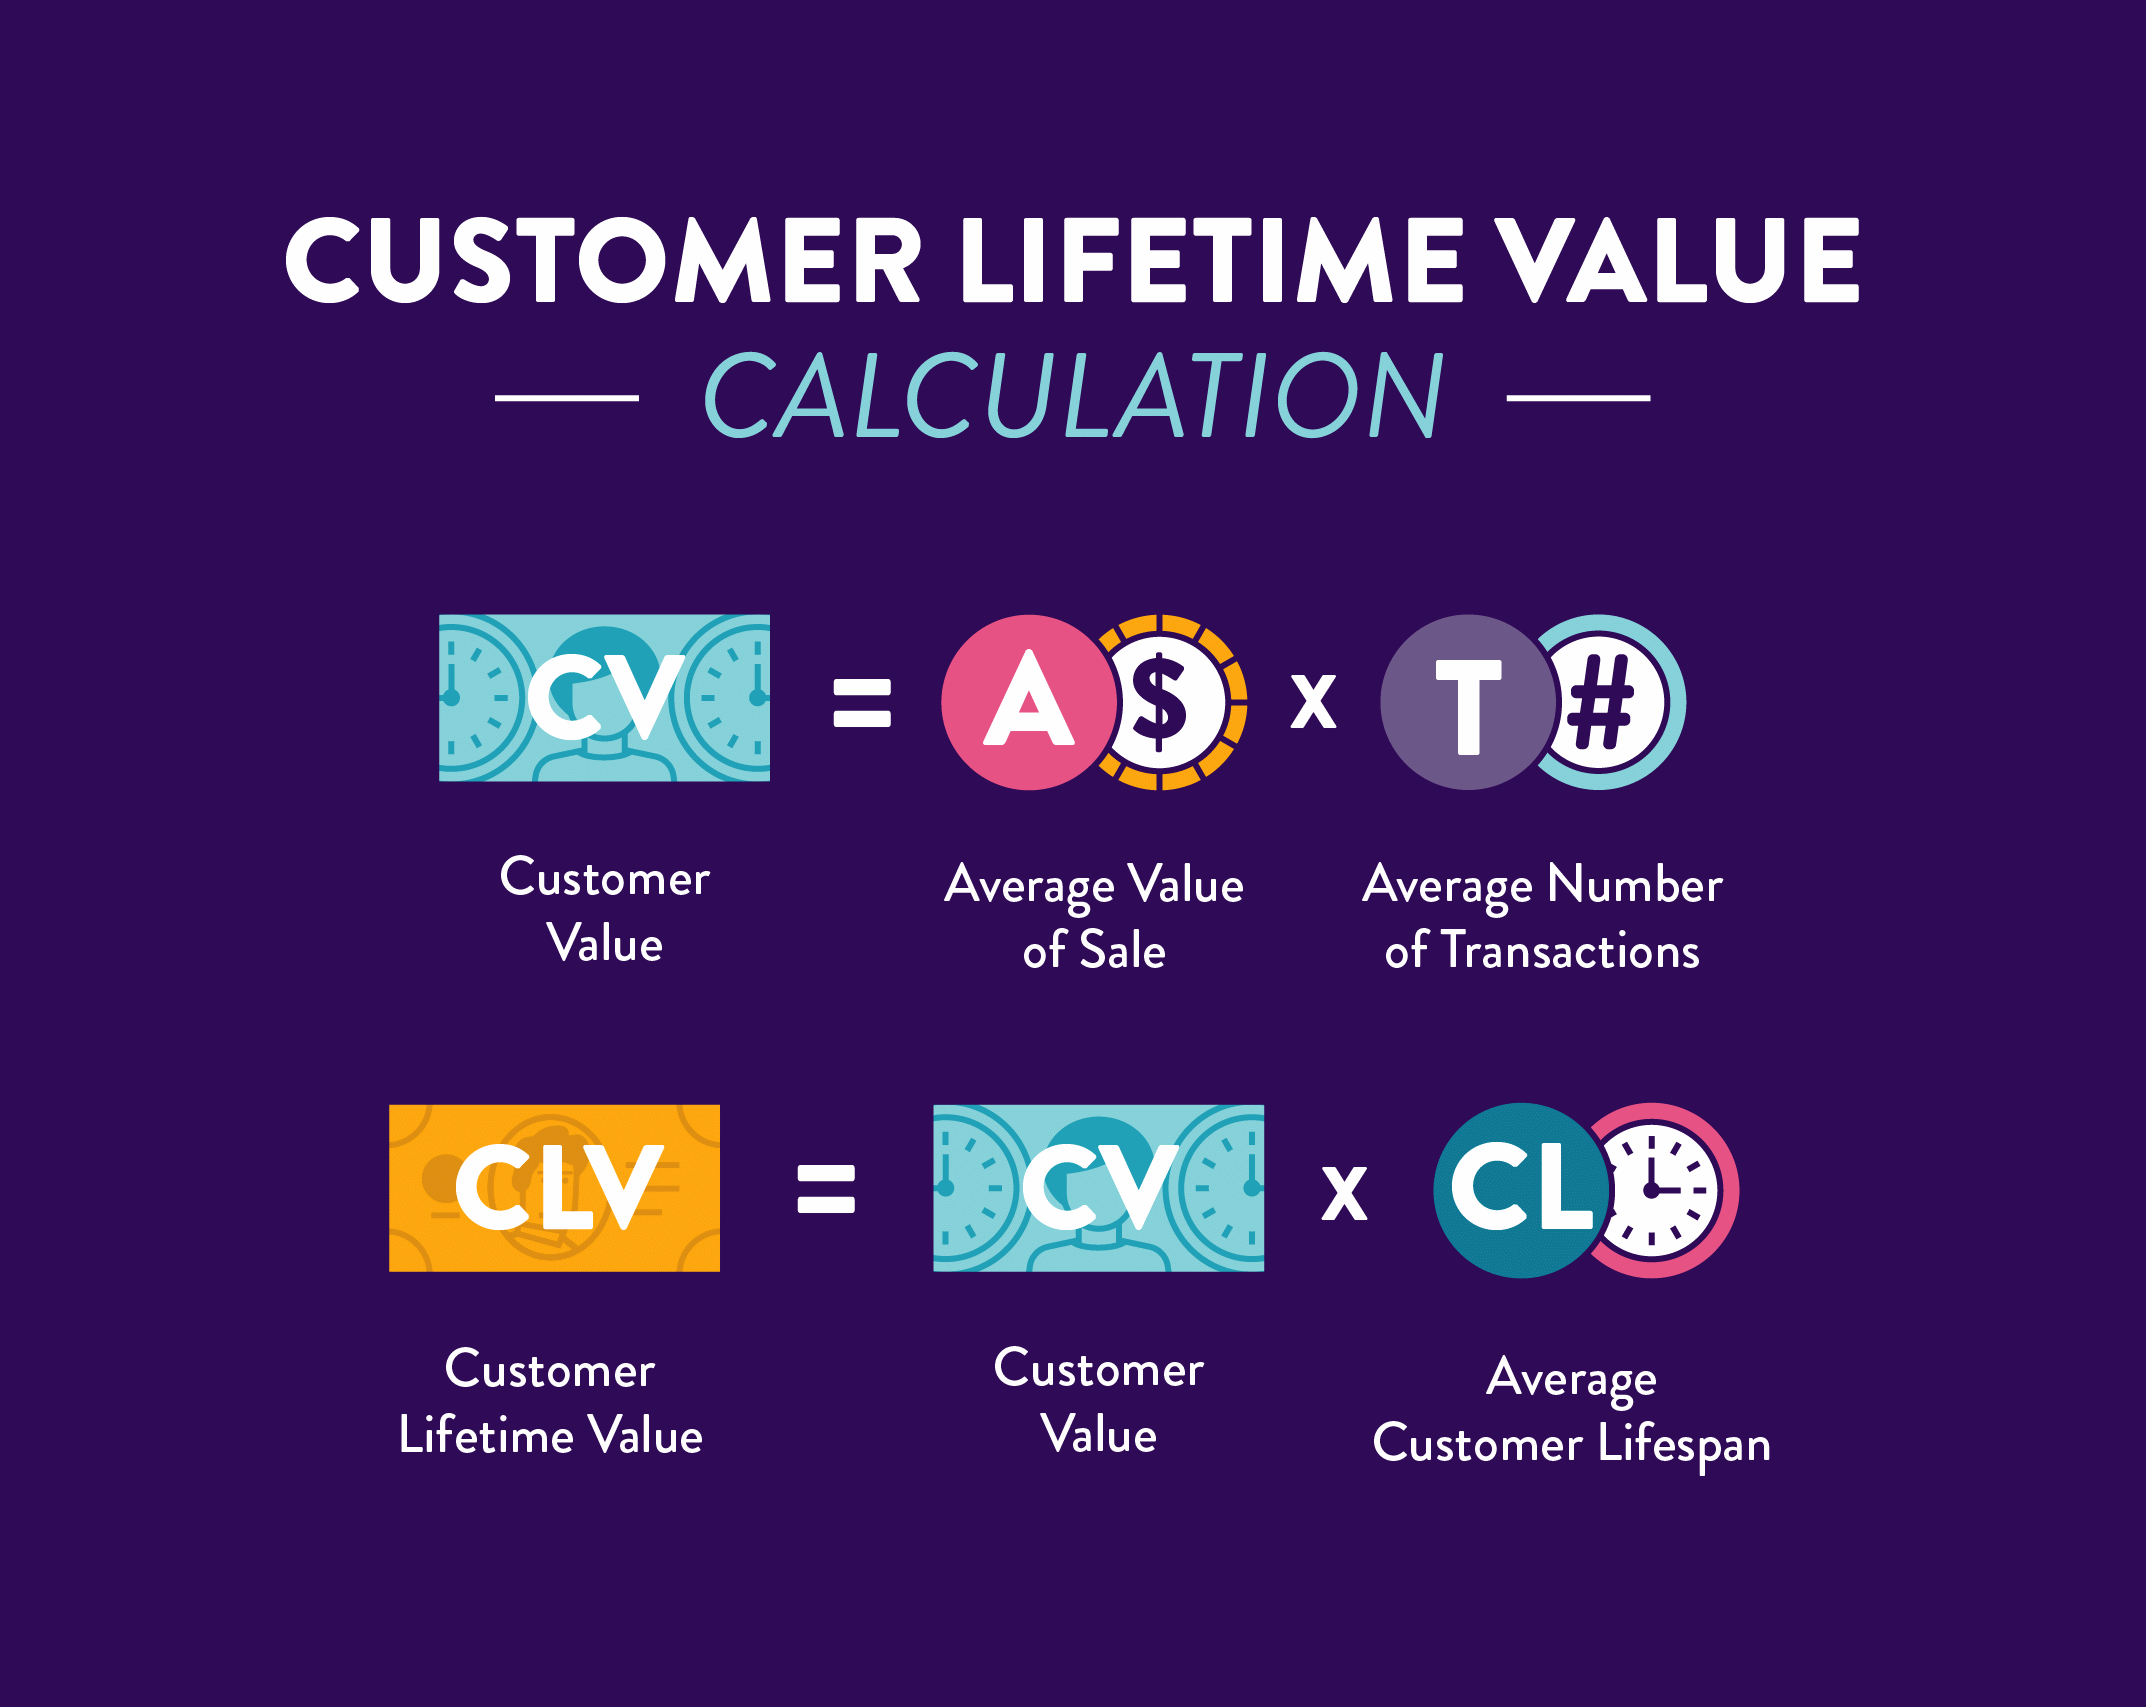

In [26]:
from IPython.display import Image, display

img_path = 'CLTV.png'
display(Image(filename=img_path, width=1500))

In [27]:
segment['AverageOrderValue'] = segment['Monetary'] / segment['Frequency']
segment['PurchaseFrequency'] = segment['Frequency'] / segment.shape[0]

segment['CustomerLifespan'] = (segment['LastSpending'] - segment['FirstPurchase']).dt.days
total_days_in_data = (pd.to_datetime('2020-12-30') - pd.to_datetime('2018-01-06')).days + 1
segment['AverageCustomerLifespan'] = segment['CustomerLifespan'] / total_days_in_data

segment['CustomerValue'] = segment['AverageOrderValue'] * segment['PurchaseFrequency']
segment['CLTV'] = segment['CustomerValue'] * segment['AverageCustomerLifespan']

col_order = ['CustomerID', 'FirstPurchase', 'LastSpending', 'TotalQuantityOrder', 'TotalSpending', 'TotalProfit', 'Recency', 'Frequency', 'Monetary', 'RFMSegment', 
             'AverageOrderValue', 'PurchaseFrequency', 'CustomerLifespan', 'AverageCustomerLifespan', 'CustomerValue', 'CLTV']
segment = segment[col_order]

print(segment.head(10).to_string())

  CustomerID FirstPurchase LastSpending  TotalQuantityOrder  TotalSpending  TotalProfit  Recency  Frequency    Monetary             RFMSegment  AverageOrderValue  PurchaseFrequency  CustomerLifespan  AverageCustomerLifespan  CustomerValue      CLTV
0          1    2018-02-07   2020-12-23                 635    1322278.500   483190.900        7        152 1322278.500     Low Value Customer           8699.201              3.040              1050                    0.963      26445.570 25475.090
1         10    2018-01-06   2020-12-17                 706    1763942.500   618305.360       13        158 1763942.500  Medium Value Customer          11164.193              3.160              1076                    0.987      35278.850 34825.727
2         11    2018-01-06   2020-12-26                 805    1883410.200   712098.980        4        178 1883410.200    High Value Customer          10580.956              3.560              1085                    0.995      37668.204 37495.414
3   

## CLTV SEGMENTATION

In [28]:
scaler = MinMaxScaler()
cltv_scale = segment[['CLTV']]
cltv_scale = scaler.fit_transform(cltv_scale)

In [29]:
possible_k_values = range(2, 11)
silhouette_scores_kmeans = []
distortions = []

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cltv_scale)
    labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(cltv_scale, labels)
    silhouette_scores_kmeans.append(silhouette_avg)
    
    distortions.append(kmeans.inertia_)

best_indices = sorted(range(len(silhouette_scores_kmeans)), key=lambda i: silhouette_scores_kmeans[i], reverse=True)[:2]
best_clusters = [possible_k_values[i] for i in best_indices]
best_scores = [silhouette_scores_kmeans[i] for i in best_indices]

print(f'The two best clusters are {best_clusters[0]} with silhouette score {best_scores[0]:.4f} and {best_clusters[1]} with silhouette score {best_scores[1]:.4f}')

The two best clusters are 7 with silhouette score 0.6510 and 2 with silhouette score 0.6435


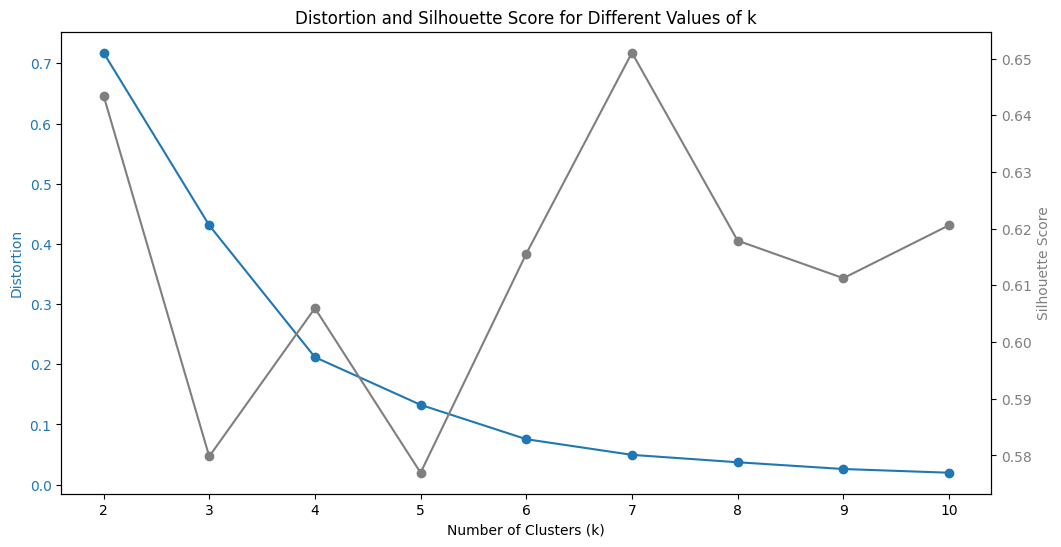

In [30]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Distortion', color='tab:blue')
ax1.plot(possible_k_values, distortions, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:grey')
ax2.plot(possible_k_values, silhouette_scores_kmeans, color='tab:grey', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:grey')

plt.title('Distortion and Silhouette Score for Different Values of k')
plt.show()

In [31]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(cltv_scale)

segment['CLTVSegment'] = kmeans.labels_
cluster_labels = {0: 'Profitable Customer', 1: 'Very Profitable Customer'}
segment['CLTVSegment'] = segment['CLTVSegment'].map(cluster_labels)

print(segment.head(10).to_string())

  CustomerID FirstPurchase LastSpending  TotalQuantityOrder  TotalSpending  TotalProfit  Recency  Frequency    Monetary             RFMSegment  AverageOrderValue  PurchaseFrequency  CustomerLifespan  AverageCustomerLifespan  CustomerValue      CLTV               CLTVSegment
0          1    2018-02-07   2020-12-23                 635    1322278.500   483190.900        7        152 1322278.500     Low Value Customer           8699.201              3.040              1050                    0.963      26445.570 25475.090       Profitable Customer
1         10    2018-01-06   2020-12-17                 706    1763942.500   618305.360       13        158 1763942.500  Medium Value Customer          11164.193              3.160              1076                    0.987      35278.850 34825.727  Very Profitable Customer
2         11    2018-01-06   2020-12-26                 805    1883410.200   712098.980        4        178 1883410.200    High Value Customer          10580.956              

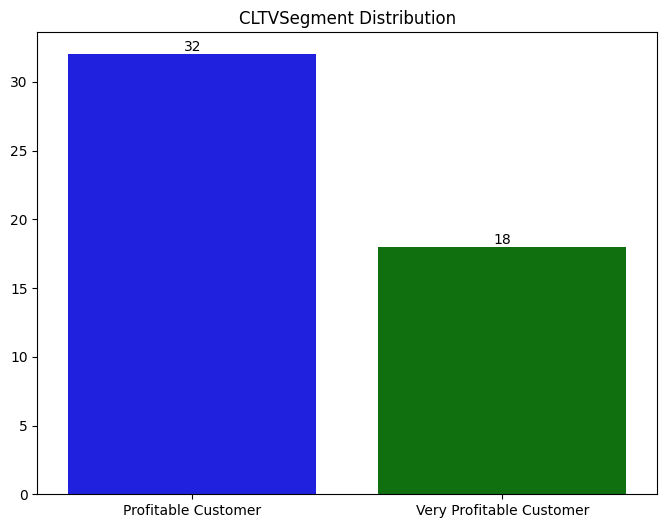

In [32]:
custom_palette = {'Profitable Customer': 'blue', 'Very Profitable Customer': 'green'}

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=segment, x=segment['CLTVSegment'], palette=custom_palette)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('CLTVSegment Distribution', loc='center', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

Text(0.5, 1.0, 'Boxplot by Cluster')

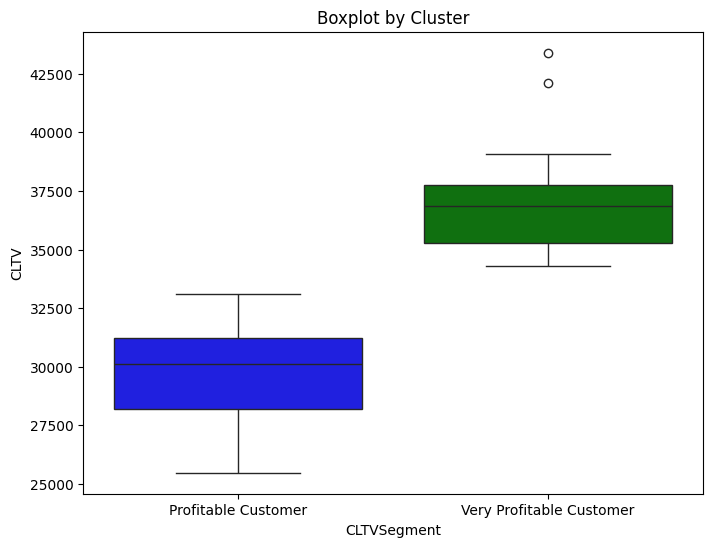

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='CLTVSegment', y='CLTV', data=segment, palette=custom_palette)
plt.title('Boxplot by Cluster')

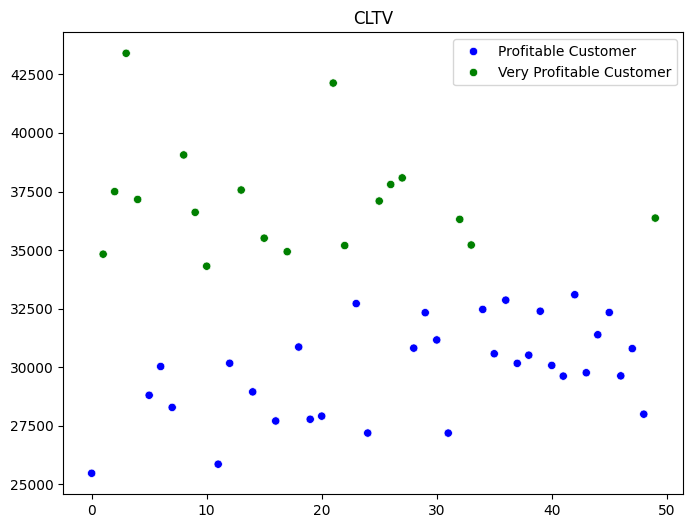

In [34]:
custom_palette = {'Profitable Customer': 'blue', 'Very Profitable Customer': 'green'}

y_variable = 'CLTV'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=segment.index, y=segment[y_variable], hue=segment['CLTVSegment'], palette=custom_palette)
plt.title(f'{y_variable}')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='')

# Show the plot
plt.show()

In [35]:
result = segment.groupby(['CLTVSegment', 'RFMSegment'])['CustomerID'].nunique()
print(result)

CLTVSegment               RFMSegment           
Profitable Customer       Low Value Customer       24
                          Medium Value Customer     8
Very Profitable Customer  High Value Customer      11
                          Medium Value Customer     7
Name: CustomerID, dtype: int64


In [36]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerID               50 non-null     object        
 1   FirstPurchase            50 non-null     datetime64[ns]
 2   LastSpending             50 non-null     datetime64[ns]
 3   TotalQuantityOrder       50 non-null     int64         
 4   TotalSpending            50 non-null     float64       
 5   TotalProfit              50 non-null     float64       
 6   Recency                  50 non-null     int64         
 7   Frequency                50 non-null     int64         
 8   Monetary                 50 non-null     float64       
 9   RFMSegment               50 non-null     object        
 10  AverageOrderValue        50 non-null     float64       
 11  PurchaseFrequency        50 non-null     float64       
 12  CustomerLifespan         50 non-null  

In [ ]:
# df = df[['CustomerID', 'OrderNumber', 'OrderDate', 'ProductID', 'OrderQuantity', 'DiscountApplied', 'UnitCost', 'UnitPrice', 'TotalPurchase', 'TotalCost', 'TotalProfit', 
#          'SalesChannel']].merge(
#      segment[['CustomerID', 'FirstPurchase', 'LastSpending', 'TotalQuantityOrder', 'Recency', 'Frequency', 'Monetary', 'RFMSegment', 
#               'AverageOrderValue', 'PurchaseFrequency', 'CustomerLifespan', 'AverageCustomerLifespan', 'CustomerValue', 'CLTV', 'CLTVSegment']],
#      on='CustomerID', how='left')

# print(df.head(10).to_string())

In [ ]:
# df.info()